In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# get the data

!cp /content/drive/MyDrive/buildingSegmentation/data.zip data.zip
!unzip data.zip

Archive:  data.zip
  inflating: label_class_dict.csv    
  inflating: metadata.csv            
  inflating: png/test/22828930_15.png  
  inflating: png/test/22828990_15.png  
  inflating: png/test/22829050_15.png  
  inflating: png/test/23429020_15.png  
  inflating: png/test/23429080_15.png  
  inflating: png/test/23578960_15.png  
  inflating: png/test/23579005_15.png  
  inflating: png/test/23729035_15.png  
  inflating: png/test/23879080_15.png  
  inflating: png/test/24179065_15.png  
  inflating: png/test_labels/22828930_15.png  
  inflating: png/test_labels/22828990_15.png  
  inflating: png/test_labels/22829050_15.png  
  inflating: png/test_labels/23429020_15.png  
  inflating: png/test_labels/23429080_15.png  
  inflating: png/test_labels/23578960_15.png  
  inflating: png/test_labels/23579005_15.png  
  inflating: png/test_labels/23729035_15.png  
  inflating: png/test_labels/23879080_15.png  
  inflating: png/test_labels/24179065_15.png  
  inflating: png/train/22678915_15.

In [3]:
# Get the trained model
!cp /content/drive/MyDrive/buildingSegmentation/v4.keras v4.keras

In [6]:
import numpy as np
from PIL import Image
from keras.models import load_model
import matplotlib.pyplot as plt
import io

# Sliding window approach

Infer large images by moving a sliding window from top-left to bottom-right and then combining predictions for each sliding window.

In [108]:
def padding(image, patch_size=256, stride=256):
    width, height = image.shape[:2]

    # Desired shape (256* 6 = 1536)
    xx = (width // stride +1) * stride
    yy = (height // stride +1) * stride

    a = xx- width
    b = yy - height
    return np.pad(image, ((0, a), (0, b), (0, 0)), mode='constant')


In [109]:
padding(np.ones((500, 236, 3))).shape

(512, 256, 3)

In [110]:
def get_sliding_window_images(image, patch_size=256, stride=256):
    """
      Returns a list of images generated by moving a sliding window
      across the image from top-left to bottom-right as well as number of rows and columns
    """
    results = []
    patches = []
    padded_image = padding(image, patch_size, stride)
    height, width = padded_image.shape[:2]

    nr, nc = int(height / stride), int(width / stride)
    # fig, axes = plt.subplots(6, 6)
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            patch = padded_image[y:y+patch_size, x:x+patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            patches.append(patch)
    return patches, nr, nc

In [111]:
def concat_results(results, nr, nc, patch_size=256, stride=256):
  """
    nr: # of rows
    nc: # of columns
  """
  # Calculate the number of patches in each dimension
  num_patches_x = nc
  num_patches_y = nr
  # Initialize the output array
  output = np.zeros((num_patches_y * patch_size, num_patches_x * patch_size))
  # Iterate over the results and concatenate them
  for i, result in enumerate(results):
    x, y = i % num_patches_x, i // num_patches_x
    output[y* patch_size:(y+1)*patch_size, x*patch_size:(x+1)*patch_size] = result[...,0]

  return output

In [112]:
def sliding_window_inference(model, image, patch_size=256, stride=256, thresh=.5):
    patches = []
    results = []
    slided_images, nr, nc = get_sliding_window_images(image, patch_size, stride)
    height, width = slided_images[0].shape[1:3]

    # slided_images : list
    for (i , el) in enumerate(slided_images):
      x = (i % 6) * patch_size
      y = (i // 6) * patch_size

      patch = slided_images[i]
      patches.append(patch / 255)

    patches_array = np.zeros((len(patches), patch_size, patch_size, 3))
    for i, patch in enumerate(patches):
      patches_array[i] = patch

    results = model.predict(patches_array)
    results = (results > thresh).astype(np.uint8)
    return concat_results(results, nr=nr, nc = nc)

In [98]:
# a sample image and mask

image = Image.open('/content/png/test/22828930_15.png')
mask = Image.open('/content/png/test_labels/22828930_15.png')

np_image = np.array(image)
np_mask = np.array(mask)

model = load_model('/content/v4.keras')

In [113]:
results = sliding_window_inference(model, np_image)

2/2 [==============================] - 13s 1s/step


Text(0.5, 1.0, 'Image')

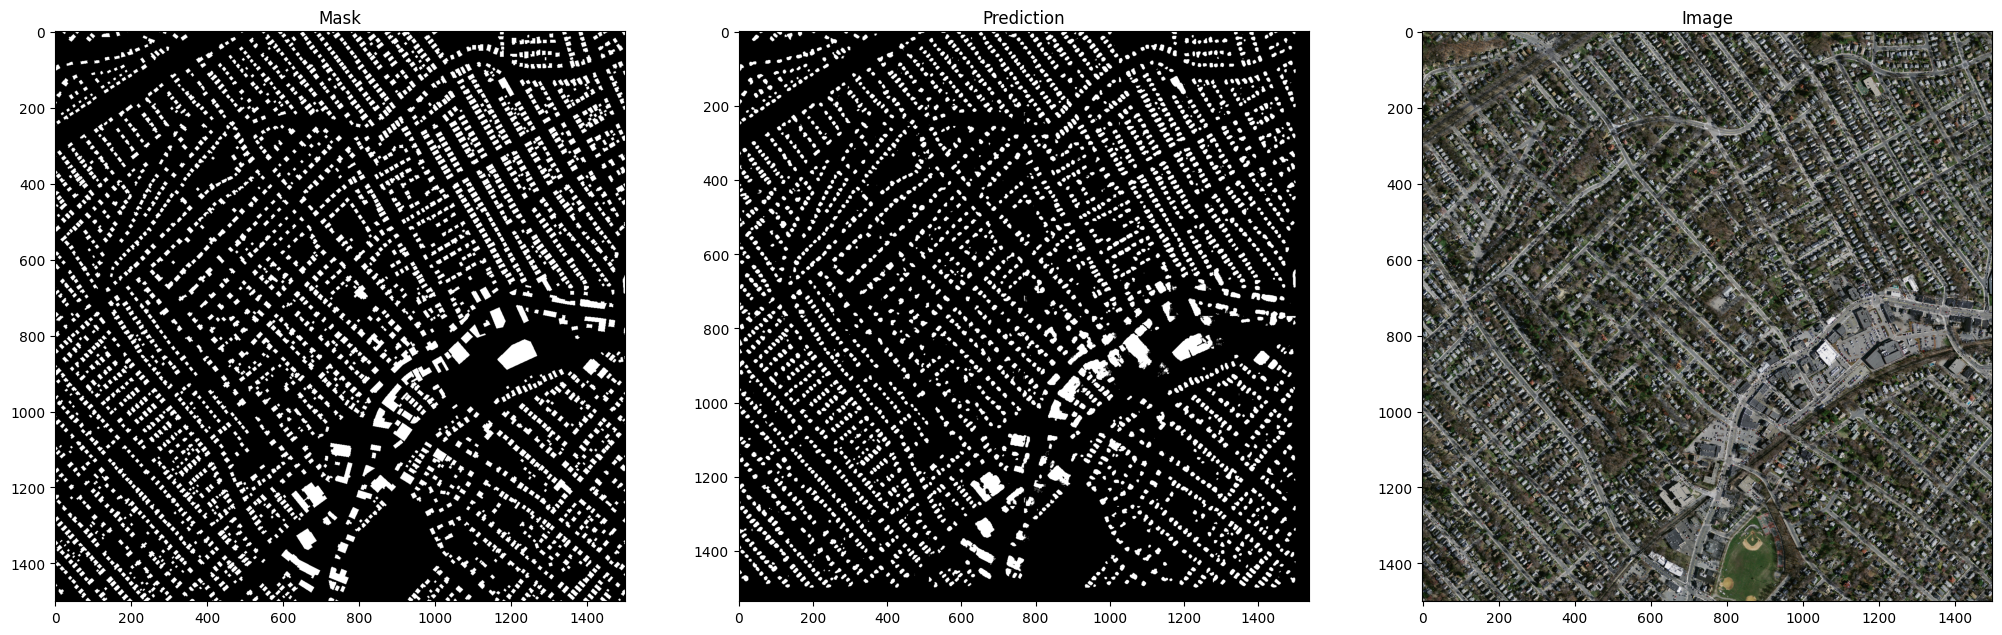

In [114]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(25, 25)
axes[0].imshow(np_mask)
axes[0].set_title("Mask")
axes[1].imshow(results, cmap="gist_gray")
axes[1].set_title("Prediction")
axes[2].imshow(np_image)
axes[2].set_title("Image")

# Load your own image for segmentation

Upload an image:


Saving 23429080_15.png to 23429080_15 (1).png
2/2 [==============================] - 11s 956ms/step


Text(0.5, 1.0, 'Prediction')

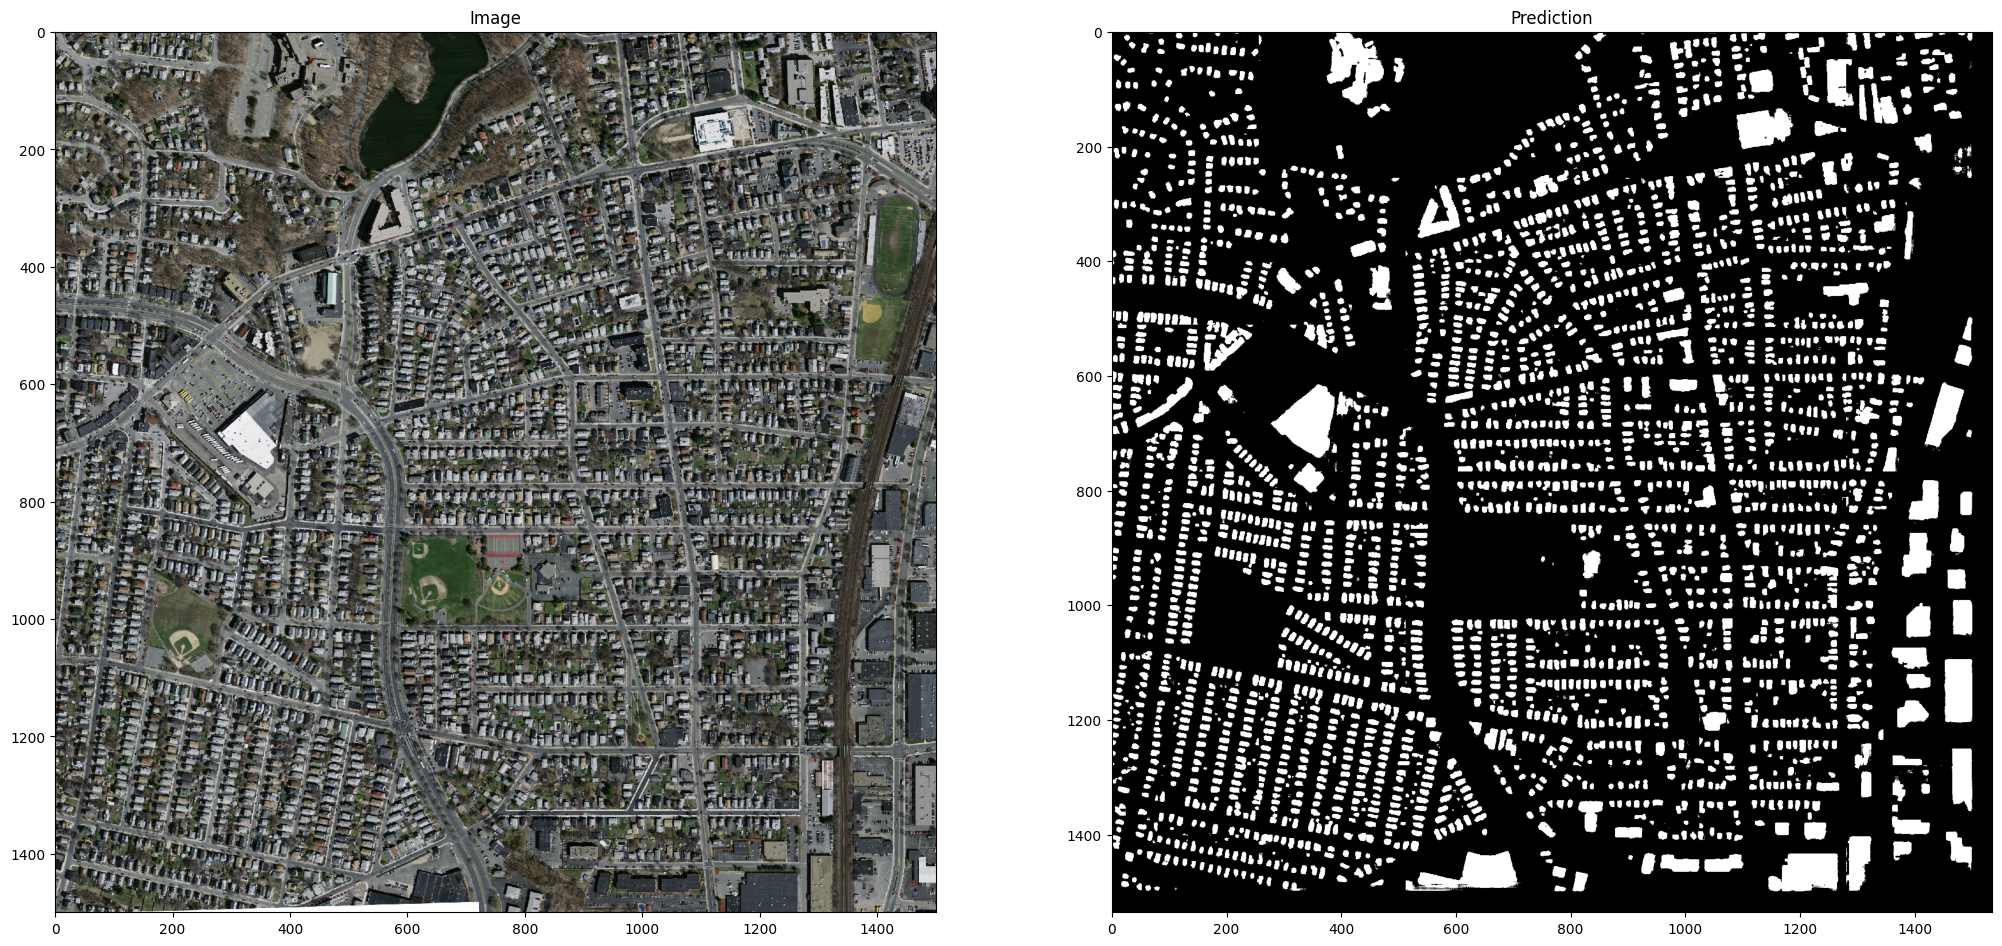

In [116]:
from google.colab import files
import io
from PIL import Image
import numpy as np

# Function to upload image and convert it to numpy array
def upload_and_convert():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_data = uploaded[fn]
        img = Image.open(io.BytesIO(img_data))
        img_array = np.array(img)
        return img_array

# Upload image
print("Upload an image:")
image_array = upload_and_convert()

pred = sliding_window_inference(model, image_array)

# Display the results
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(25, 25)

axes[0].imshow(image_array)
axes[0].set_title("Image")

axes[1].imshow(pred, cmap="gist_gray")
axes[1].set_title("Prediction")